In [ ]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# twinLab import
import twinlab as tl
tl.set_api_key("")

    Temperatures  Ln_permeation
0    1040.721757     -21.287857
1     802.000776     -22.947361
2     913.661346     -22.063188
3     688.130410     -24.144548
4     704.106868     -23.953225
5    1032.044780     -21.334731
6     701.645321     -23.982135
7     529.420369     -26.534766
8     621.013837     -24.688791
9     506.117706     -27.111023
10    688.143424     -23.647920
11    534.190762     -26.422997
12    498.074551     -27.322442
13    598.469498     -25.090727
14    310.263034     -34.740539
15    320.211487     -34.101425
16    318.940481     -34.180856
17    316.179868     -34.355580
18    303.202681     -35.219558
19    298.268475     -35.567789
20    322.700148     -33.947709
21    707.842943     -23.576461
22    640.264104     -24.580082
23    739.320656     -23.171616
24    598.730291     -25.309315
25    699.646504     -23.687856
26    621.658221     -24.894708
27    611.137563     -25.081091
28    897.173622     -21.982265
29    744.614260     -23.492808
30    73

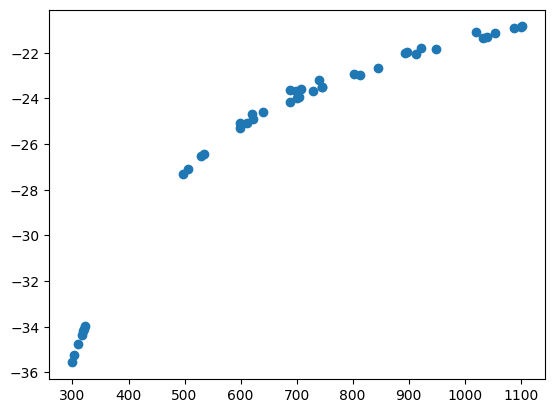

In [7]:
kb = 8.61733326E-5
def Permeation(params,T):
    
    P = params["P0"]*np.exp(-params["Ep"]/(kb*T))
    return P

params_DM122 = {
"Ep" : 0.65,
"P0" : 2.7E-8,
"Trange":[673,1073] 
}

params_DM123={
"Ep" : 0.5,
"P0" : 1.5E-7, 
"Trange": [673,1073] 
}

# params_DM124={
# "Ep" : 0.68,
# "P0" : 3.48E-7, 
# "Trange": [707,900] 
# }
# remove 124 as it is not pure nickel

params_DM141={
"Ep" : 0.5710,
"P0" : 8.16E-7, 
"Trange": [473,693] 
}

params_DM142={
"Ep" : 0.550,
"P0" : 7.02E-7, 
"Trange": [298,353] 
}

params_DM143={
"Ep" : 0.580,
"P0" : 7.77E-7, 
"Trange": [573,753] 
}

params_DM144={
"Ep" : 0.57,
"P0" : 4.52E-7, 
"Trange": [723,1123] 
}

params_DM145={
"Ep" : 0.57,
"P0" : 3.56E-7, 
"Trange": [723,1123] 
}

params_all = [params_DM123,params_DM141,params_DM142,params_DM143,params_DM144,params_DM145]

df = pd.DataFrame({
    "Temperatures": np.array([]),
    "Ln_permeation": np.array([]),
})

for Par in params_all:

    Ts = np.random.uniform(1/Par["Trange"][1],1/Par["Trange"][0], 7)
    Ps = Permeation(Par,1/Ts)
    for t in range(len(Ts)):
        new_row = {    "Temperatures": 1/Ts[t],
        "Ln_permeation": np.log(Ps[t]),}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
print(df)

plt.plot(df["Temperatures"],df["Ln_permeation"],marker="o",linestyle="")
plt.show()

train_df = df.copy()
# train_df = 

# # Convert X values to CSV string
x_csv = train_df[['Temperatures']].to_csv(index=False)

# # Convert Y values to CSV string
y_csv = train_df[['Ln_permeation']].to_csv(index=False)

In [8]:
# Define the name of the dataset
dataset_id = "Tritium_Transport"

# Intialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset
dataset.upload(train_df, verbose=True)

Dataframe is uploading.
Dataset successfully uploaded.


In [9]:
# Initialise emulator
emulator_id = "Tritium_Transport_Emulator"

emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
output_columns = ["Ln_permeation"]
params = tl.TrainParams(
    train_test_ratio=1,
    estimator="gaussian_process_regression",
)

# Train the emulator using the train method
emulator.train(
    dataset=dataset,
    inputs=["Temperatures"],
    outputs=output_columns,
    params=params,
    verbose=True,
)

Emulator 'Tritium_Transport_Emulator' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:08: Job status: processing
0:00:10: Job status: processing
0:00:13: Job status: success
Training of emulator Tritium_Transport_Emulator is complete!


In [10]:
test_df = pd.DataFrame({"Temperatures":np.linspace(200,1500,200)})
y_pred,y_std = emulator.predict(test_df)

Job predict process ID: predict-magnetic-electric-bonnet
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:06: Job status: success
Mean predictions:
     Ln_permeation
0       -39.558932
1       -39.305527
2       -39.045750
3       -38.780001
4       -38.508694
..             ...
195     -23.577237
196     -23.679771
197     -23.782972
198     -23.886746
199     -23.990995

[200 rows x 1 columns]
Standard deviation predictions:
     Ln_permeation
0         0.585543
1         0.541669
2         0.499734
3         0.459817
4         0.422002
..             ...
195       2.881156
196       2.940906
197       2.999755
198       3.057651
199       3.114547

[200 rows x 1 columns]


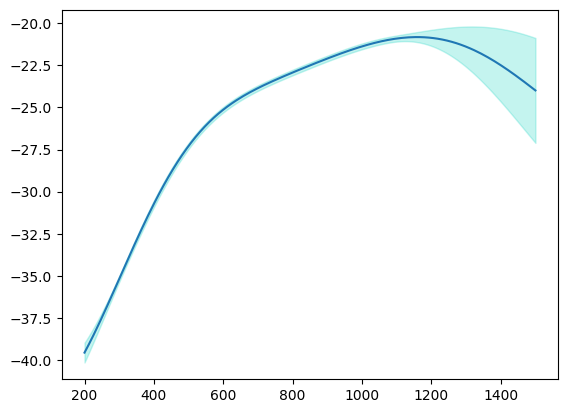

In [16]:
plt.plot(test_df,y_pred)
plt.fill_between(
    test_df["Temperatures"],
    (y_pred["Ln_permeation"] -  y_std["Ln_permeation"]),
    (y_pred["Ln_permeation"] +  y_std["Ln_permeation"]),
    color="#16D4C2",
    alpha=0.25,
    label="Model Confidence Interval",
)

In [21]:
df_obs = pd.DataFrame({'Ln_permeation': [-21]})
df_std = pd.DataFrame({'Ln_permeation': [0.1]})
calib_params = tl.CalibrateParams(return_summary=False)
df_calib = emulator.calibrate(df_obs, df_std,params=calib_params)

Job calibrate process ID: calibrate-regal-polite-provelone
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:06: Job status: processing
0:00:08: Job status: processing
0:00:10: Job status: processing
0:00:13: Job status: processing
0:00:17: Job status: processing
0:00:20: Job status: processing
0:00:24: Job status: processing
0:00:28: Job status: processing
0:00:33: Job status: processing
0:00:38: Job status: processing
0:00:44: Job status: processing
0:00:50: Job status: processing
0:00:57: Job status: success
Calibration:
       chain  draw  Temperatures
0          0     0   1066.220391
1          0     1   1066.220391
2          0     2   1066.220391
3          0     3   1066.220391
4          0     4   1066.220391
...      ...   ...           ...
16665      1  8330   1050.876962
16666      1  8331   1078.291054
16667      1  8332   1078.291054
16668      1  8333   1067.554205
16669      1  8334   1067.554205

[16670 rows x 3 column

In [25]:
print(np.array(df_calib["Temperatures"]))

[1066.22039075 1066.22039075 1066.22039075 ... 1078.29105355 1067.55420545
 1067.55420545]
